# Hidden Markov Models for Event Segmentation
**V.0.2 - beta, [contributions](#contributions)**

If asked to give a quick description of a dinner meeting with friends, it could be the following: "First, we met outside the restaurant while waiting for our table. Once we got to our table, we continued talking for a bit before we ordered something to drink and a few appetizers. Later, everyone ordered their dinner. The food arrived after some time and we all began eating. Finally, it was time for dessert and we continued chatting with each other until desert arrived. After this, we split the bill and headed out of the restaurant. We said our goodbyes to each other, while waiting for our taxis, and went home." In this description, one can easily discern that the dinner meeting had certain stages, or events, that occurred sequentially. Furthermore, these events can be perceived at varying scales. At the longest time scale, the entire dinner meeting could be treated as one event. At smaller time scales, subsets of the meeting such as entering the restaurant, taking off coats, being seated, looking at menus and so on, can be treated as different events. At an even smaller scale, the event of entering the restaurant can be broken up into different sub-events. Regardless of the scale, all of these accounts share the property that the event can be represented as a sequence of stages. 

The goal of this week’s lab is to explore methods for finding these “sequence-of-stages” representations in the brain. To accomplish this, we use a machine learning technique called Hidden Markov Modeling. Hidden Markov Models (HMM) assume that your thoughts progress through a sequence of states, one at a time. You can’t directly observe people’s thoughts, so the states are “hidden” (not directly observable). However, you can directly observe BOLD activity. So the full specification of the HMM is that each “hidden” state (corresponding to thinking about a particular stage of an event) has an observable BOLD correlate (specifically, a spatial pattern across voxels). The goal of HMM analysis is to take the BOLD data timeseries and then infer the sequence of states that the participant’s brain went through, based on the BOLD activity. Note that the broadest formulation of an HMM allows transitions between all possible states (e.g., if you have three possible states, the HMM allows some probability of transitioning from S1 to S2, S1 to S3, S2 to S1, S2 to S3, S3 to S1, S3 to S2). However, in the formulation of the HMM used here, we will assume that the participant’s brain can only progress forward between adjacent states (S1 to S2, S2 to S3). This more limited formulation of the HMM is well-suited to situations where we know that events proceed in a stereotyped sequence (e.g., we know that the waiter brings the food after you order the food, not the other way around). 

In summary: The HMM analysis used here makes the assumption that the time series of BOLD activity was generated by the participant’s brain progressing through a sequence of states, where each state corresponds to a particular spatial pattern of BOLD activity. Intuitively, when we do HMM analysis, we are trying to identify (from the BOLD time series) when the brain has transitioned from one of the hidden stages to another, by looking at the BOLD time series and estimating when the spatial pattern has switched. By fitting HMM models with different numbers of hidden stages to BOLD data from a region, we can identify the number of hidden stages that best describes the region’s time series, and also when these transitions occur. In this notebook, we will apply the HMM to fMRI data from watching and recalling a movie (from [Chen et al., 2017](https://www.nature.com/articles/nn.4450)), with the goal of 1) identifying how different brain regions chunk the movie at different time scale, and 2) identifying brain regions where recalling a movie evokes the same sequence of neural patterns as viewing the movie. A full description of the model is given in [Baldassano, et al. (2017)](https://doi.org/10.1016/j.neuron.2017.06.041).

<img src="imgs/lab12/hmm_schematics.png" width="800">

A schematic diagram of HMM, from Baldassano, et al. 2017.

- (A) Given a set of (unlabeled) time courses from a region of interest, the goal of the event segmentation model is to temporally divide the data into ‘‘events’’ with stable activity patterns, punctuated by ‘‘event boundaries’’ at which activity patterns rapidly transition to a new stable pattern. The number and locations of these event boundaries can then be compared across brain regions or to stimulus annotations.
- (B) The model can identify event correspondences between datasets (e.g., responses to movie and audio versions of the same narrative) that share the same sequence of event activity patterns, even if the duration of the events is different.
- (C) The model-identified boundaries can also be used to study processing evoked by event transitions, such as changes in hippocampal activity coupled to event transitions in the cortex.
- (D) The event segmentation model is implemented as a modified Hidden Markov Model (HMM) in which the latent state s
t for each time point denotes the event to which that time point belongs, starting in event 1 and ending in event K. All datapoints during event K are assumed to be exhibit high similarity with an event- specific pattern m
k.



## Goal of this script
    1. Understand how HMMs can be useful in analyzing time series data.  
    2. Learn the how to run HMM in BrainIAK (`brainiak.eventseg`).
    3. Use HMM to infer event segments from brain activity.
    4. Determine the statistical significance of the results from the HMM.  

    
<br>


## Table of Contents
[0. HMM with toy data](#hmm_toy)  
[1. Detect event boundaries from brain activity](#hmm_brain)
>[1.1 Data loading](#load_data)  
>[1.2 Formal procedure for fitting HMM](#fit_hmm)  
>>[1.2.1 The inner loop: tune `k`](#tune_k)  
>>[1.2.2 Outer loop: Statistical testing for model boundaries](#stats_hmm)

[2. Comparing model boundaries to human-labeled boundaries](#model_to_human)

[3. Aligning movie and recall data](#movie_to_recall)  
>[3.1. Fit HMM on the two datasets](#fit_movie_to_recall).  
>[3.2 Compare the time scale of events between semantic and sensory regions](#movie_to_recall_semantic_sensory)  


### Exercises:  
>[1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8) 

>[Novel contribution](#novel) 

In [1]:
import warnings
import sys 
import os    
# import logging

import deepdish as dd
import numpy as np

import brainiak.eventseg.event
import nibabel as nib
from nilearn.input_data import NiftiMasker

import scipy.io
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
from sklearn.model_selection import LeaveOneOut, KFold

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns 

%autosave 5
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

if not sys.warnoptions:
    warnings.simplefilter("ignore")

data_path = './data'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    print(f'Make dir {data_path}')
else: 
    print('Data path exists')

/home/NEU350/software/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Autosaving every 5 seconds
Data path exists


## 0. Intro-to BrainIAK.HMM with a toy simulation <a id="hmm_toy"></a>

Here, we introduce the usage of HMM in BrainIAK with a toy simulation. In particular, we will generate data with a known number, $ K $, of event boundaries. The following steps are used to run this simulation:
> 1. Create event labels for each time-point in the toy dataset using `generate_event_labels`.  
> 2. Create data with these event labels using `generate_data`.  
> 3. Check the data matrix to see if we have created events -- time periods where the signal is relatively constant.  
> 4. Segment the signal using the brainiak HMM function: ` brainiak.eventseg.event.EventSegment(K)`.  
> 5. Overlay the results from HMM with the ground truth segments from the data.  

In [2]:
def generate_event_labels(T, K, length_std):
    event_labels = np.zeros(T, dtype=int)
    start_TR = 0
    for e in range(K - 1):
        length = round(
            ((T - start_TR) / (K - e)) * (1 + length_std * np.random.randn()))
        length = min(max(length, 1), T - start_TR - (K - e))
        event_labels[start_TR:(start_TR + length)] = e
        start_TR = start_TR + length
    event_labels[start_TR:] = K - 1

    return event_labels


def generate_data(V, T, event_labels, event_means, noise_std):
    simul_data = np.empty((V, T))
    for t in range(T):
        simul_data[:, t] = stats.multivariate_normal.rvs(
            event_means[:, event_labels[t]], cov=noise_std, size=1)

    simul_data = stats.zscore(simul_data, axis=1, ddof=1)
    return simul_data

### 0.1 Create and plot simulated data.

Create and view the simulated data. Imagine the following matrix is the voxel by TR bold activity matrix, averaged across participants.

Text(0.5,0,'Timepoints')

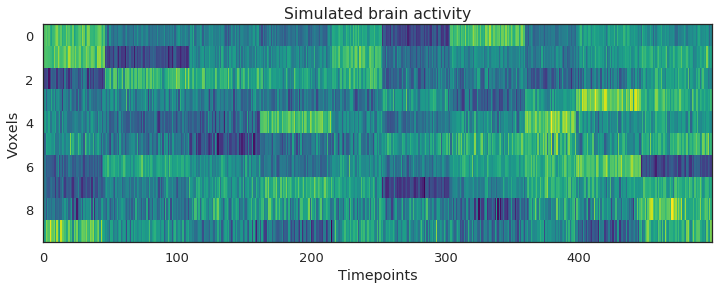

In [3]:
# Parameters for creating small simulated datasets
V = 10 # number of voxels
K = 10 # number of events
T = 500 # Time points

# Generate the first dataset
np.random.seed(1)
event_means = np.random.randn(V, K)
event_labels = generate_event_labels(T, K, 0.2)
D = generate_data(V, T, event_labels, event_means, 1/4)

# Check the data. 
f, ax = plt.subplots(1,1, figsize=(12, 4))
ax.imshow(D, interpolation='nearest', cmap='viridis', aspect='auto')
ax.set_ylabel('Voxels')
ax.set_title('Simulated brain activity')
ax.set_xlabel('Timepoints')

### 0.2 Check if events have been created.

The goal of the HMM is to identify chunks of time during which activity patterns remain relatively constant. To see if this is a reasonable model for our dataset, we can plot a timepoint-timepoint correlation matrix, showing the similarity between every pair of timepoints in our dataset (averaged over subjects).

Text(0,0.5,'TR')

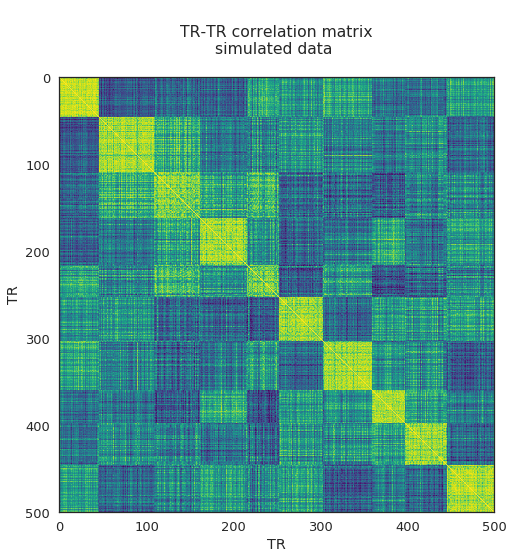

In [4]:
f, ax = plt.subplots(1,1, figsize = (10,8))
ax.imshow(np.corrcoef(D.T), cmap='viridis')
title_text = '''
TR-TR correlation matrix
simulated data 
'''
ax.set_title(title_text)
ax.set_xlabel('TR')
ax.set_ylabel('TR')

### 0.3 Run HMM on simulated data.

Calling `brainiak.eventseg.event.EventSegment(k)` fits a hidden markov model with parameter `k`, where `k` is your guess about how many events (or brain states) are in the data. Here we are using the ground truth number of events. 

In [5]:
# Find the events in this dataset
hmm_sim = brainiak.eventseg.event.EventSegment(K)
hmm_sim.fit(D.T)

EventSegment(n_events=10, n_iter=500,
       step_var=<function EventSegment._default_var_schedule at 0x2adb428fc488>)

Another output of the event segmentation fit is the estimated activity pattern for each event: `HMM.event_pat_`.

Text(0.5,0,'Voxels')

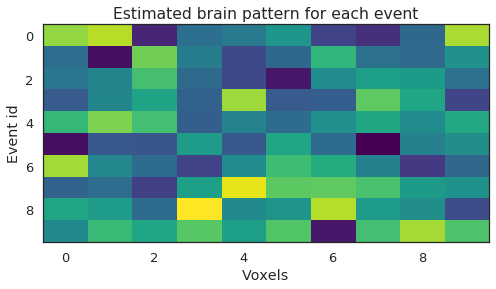

In [6]:
f, ax = plt.subplots(1,1, figsize=(8, 4))

ax.imshow(hmm_sim.event_pat_.T, cmap='viridis', aspect='auto')
ax.set_title('Estimated brain pattern for each event')
ax.set_ylabel('Event id')
ax.set_xlabel('Voxels')

One way of visualizing the fit is to mark on the timepoint correlation matrix where the model thinks the borders of the events are. The (soft) event segmentation is in `HMM.segments_[0]`, so we can convert this to hard bounds by taking the argmax.

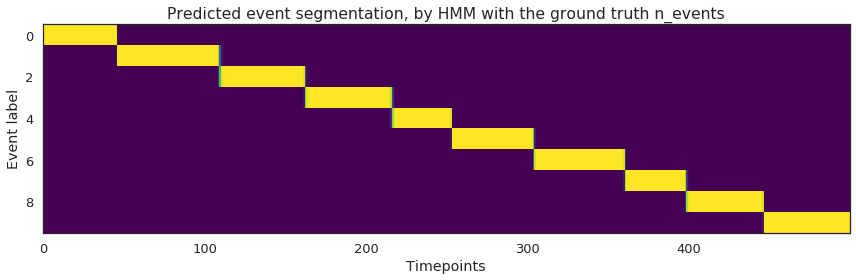

In [7]:
# plot 
f, ax = plt.subplots(1,1, figsize=(12,4))

pred_seg = hmm_sim.segments_[0]
ax.imshow(pred_seg.T, aspect='auto', cmap='viridis')
ax.set_xlabel('Timepoints')
ax.set_ylabel('Event label')
ax.set_title('Predicted event segmentation, by HMM with the ground truth n_events')

f.tight_layout()

**Exercise 1**:<a id="ex1"></a> Inspect `hmm_sim.segments_[0]`. You may reference BrainIAK documentation to learn more: http://brainiak.org/docs/brainiak.eventseg.html

- What is it? 
- If we sum over event ids, we should get 1 for all TRs. Verify this claim. Why is this the case?  

**A**: ```hmm_sim.segments_[0]``` is an array of (time x event) data (specifically, 500 timepoints by 10 events), which is the learned segmentation. Below I verify we get 1 for all TRs by summing over event ids. This is because these are probabilities that the timepoints fall into the event id.

In [12]:
print(pred_seg)
print(pred_seg.shape)

[[1.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [1.00000000e+000 2.60563239e-084 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [1.00000000e+000 2.61198730e-082 6.93621449e-116 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 3.82553746e-112
  1.81999319e-083 1.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  3.25978670e-085 1.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 1.00000000e+000]]
(500, 10)


In [11]:
np.sum(pred_seg, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

#### 0.3.1 Log Likelihood

The field `HMM.ll_` stores the log likelihood over optimization steps. A description of what is meant by log-likelihood is provided [here](https://towardsdatascience.com/probability-concepts-explained-maximum-likelihood-estimation-c7b4342fdbb1).

In the plot below, the likelihood values closer to zero are actually larger e.g. -500 > -900, because they are logs. Also note that the HMM is optimized around 120 iterations in this example.

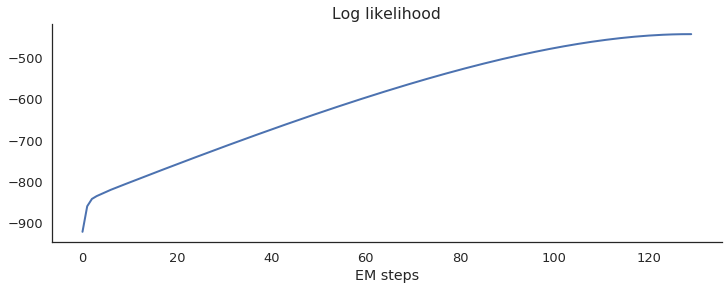

In [17]:
f, ax = plt.subplots(1,1, figsize=(12, 4))

ax.plot(hmm_sim.ll_)
ax.set_title('Log likelihood')
ax.set_xlabel('EM steps')
sns.despine()

### 0.4 Overlay the results from HMM onto the TR-by-TR correlation matrix.

Here we overlay the predicted event boundaries on top of the TR-TR similarity matrix, which shows HMM is doing a great job recovering the ground truth. 

In [18]:
def plot_tt_similarity_matrix(ax, data_matrix, bounds, n_TRs, title_text):
    ax.imshow(np.corrcoef(data_matrix.T), cmap='viridis')
    ax.set_title(title_text)
    ax.set_xlabel('TR')
    ax.set_ylabel('TR')
    # plot the boundaries 
    bounds_aug = np.concatenate(([0],bounds,[n_TRs]))
    for i in range(len(bounds_aug)-1):
        rect = patches.Rectangle(
            (bounds_aug[i],bounds_aug[i]),
            bounds_aug[i+1]-bounds_aug[i],
            bounds_aug[i+1]-bounds_aug[i],
            linewidth=2,edgecolor='w',facecolor='none'
        )
        ax.add_patch(rect)

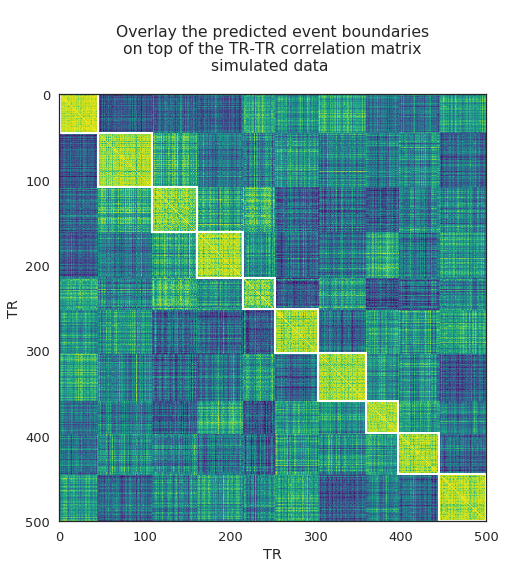

In [19]:
# extract the boundaries 
bounds = np.where(np.diff(np.argmax(pred_seg, axis=1)))[0]

f, ax = plt.subplots(1,1, figsize = (10,8))
title_text = f'''
Overlay the predicted event boundaries
on top of the TR-TR correlation matrix
simulated data 
'''
plot_tt_similarity_matrix(ax, D, bounds, T, title_text)
f.tight_layout()

**Exercise 2**: <a id="ex1"></a> Study the effects of over/under-estimating k. 

- Fit HMM with k = 5, 20. 
- Visualize the boundaries on top of the TR-TR similarity matrices. 

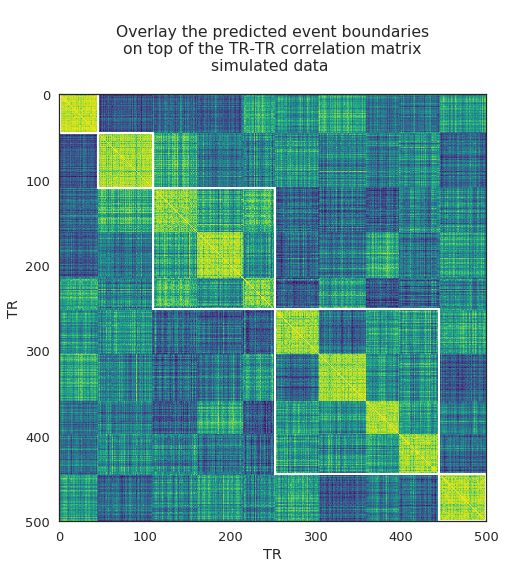

In [21]:
# K = 5

# Find the events in this dataset
hmm_sim = brainiak.eventseg.event.EventSegment(5)
hmm_sim.fit(D.T)
pred_seg = hmm_sim.segments_[0]

# extract the boundaries 
bounds = np.where(np.diff(np.argmax(pred_seg, axis=1)))[0]

f, ax = plt.subplots(1,1, figsize = (10,8))
title_text = f'''
Overlay the predicted event boundaries
on top of the TR-TR correlation matrix
simulated data 
'''
plot_tt_similarity_matrix(ax, D, bounds, T, title_text)
f.tight_layout()

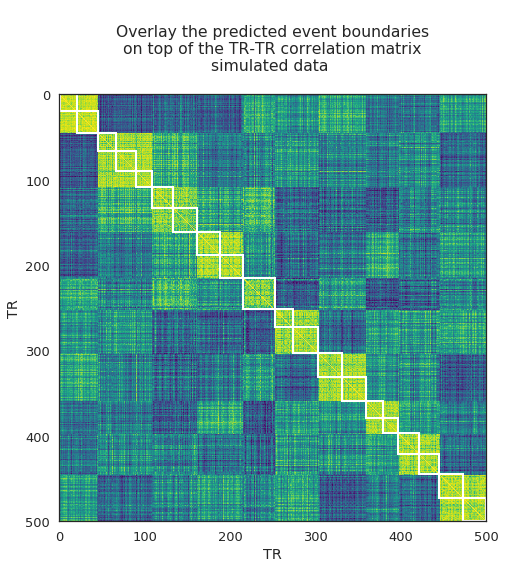

In [22]:
# K = 20

# Find the events in this dataset
hmm_sim = brainiak.eventseg.event.EventSegment(20)
hmm_sim.fit(D.T)
pred_seg = hmm_sim.segments_[0]

# extract the boundaries 
bounds = np.where(np.diff(np.argmax(pred_seg, axis=1)))[0]

f, ax = plt.subplots(1,1, figsize = (10,8))
title_text = f'''
Overlay the predicted event boundaries
on top of the TR-TR correlation matrix
simulated data 
'''
plot_tt_similarity_matrix(ax, D, bounds, T, title_text)
f.tight_layout()

## 1. Detect event boundaries from brain activity <a id="hmm_brain"></a>

In this section, we will use HMM on a movie dataset. Subjects were watching the first hour of [A Study in Pink](https://en.wikipedia.org/wiki/A_Study_in_Pink), henceforth called the "Sherlock" dataset. Please refer to the following paper if you would like to learn more about this dataset. 

- Chen, J., Leong, Y. C., Honey, C. J., Yong, C. H., Norman, K. A., & Hasson, U. (2017). Shared memories reveal shared structure in neural activity across individuals. Nature Neuroscience, 20(1), 115–125. https://doi.org/10.1038/nn.4450

### 1.1 Load data <a id="load_data"></a>

First, download whole-brain data for 17 subjects. Voxels with low intersubject correlation (that were not consistently activated across subjects) were removed, and then the data was downsampled into 141 large regions (from a [resting-state atlas](http://www.dpmlab.org/peerj-784.pdf)). After putting this .h5 file into the same directory as this notebook, we can load in the data. In addition to the BOLD fMRI data, we have the coordinates of each region, as well as human-labeled boundaries for event boundaries.

In [23]:
# download the data, just need to run these lines once
!wget https://ndownloader.figshare.com/files/9017983 -O ./data/sherlock.h5
!wget https://ndownloader.figshare.com/files/9055612 -O ./data/AG_movie_1recall.h5

--2018-12-06 13:52:15--  https://ndownloader.figshare.com/files/9017983
Resolving myadroit (myadroit)... 172.21.2.7
Connecting to myadroit (myadroit)|172.21.2.7|:8080... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/9017983/sherlock.h5 [following]
--2018-12-06 13:52:15--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/9017983/sherlock.h5
Connecting to myadroit (myadroit)|172.21.2.7|:8080... connected.
Proxy request sent, awaiting response... 200 OK
Length: 18951840 (18M) [binary/octet-stream]
Saving to: ‘./data/sherlock.h5’

100%[======================================>] 18,951,840  3.53MB/s   in 13s    

2018-12-06 13:52:28 (1.44 MB/s) - ‘./data/sherlock.h5’ saved [18951840/18951840]

--2018-12-06 13:52:29--  https://ndownloader.figshare.com/files/9055612
Resolving myadroit (myadroit)... 172.21.2.7
Connecting to myadroit (myadroit)|172.21.2.7|:8080... connected.
Proxy request sent, awaiting response...

In [24]:
# check data 
assert os.path.exists(f'{data_path}/sherlock.h5'), f'Oops you need to download sherlock.h5' 
assert os.path.exists(f'{data_path}/AG_movie_1recall.h5'), f'Oops you need to download AG_movie_1recall.h5'

In [25]:
D = dd.io.load(os.path.join(data_path, 'sherlock.h5'))
BOLD = D['BOLD']
coords = D['coords']
human_bounds = D['human_bounds']

**Exercise 3: <a id="ex3"></a> Inspect the data**
1. What is `BOLD`? Which dimension corresponds to number of subjects / number of brain regions / number of TRs? Visualize the data for the 1st subject. 
2. What is `coords`? Visualize it with a 3D plot. 
3. What is `human_bounds`? Print out this variable; Explain what's the i-th entry of this list. 

In [27]:
BOLD.shape

(141, 1976, 17)

**A (3.1)**: BOLD is the fMRI data for 17 different subjects and has dimensions #regions x #TRs x #subjs.

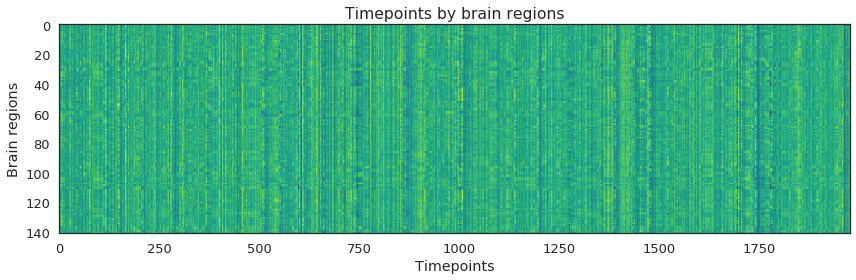

In [33]:
to_plot = BOLD[:,:,0]

# plot 
f, ax = plt.subplots(1,1, figsize=(12,4))

ax.imshow(to_plot, aspect='auto', cmap='viridis')
ax.set_xlabel('Timepoints')
ax.set_ylabel('Brain regions')
ax.set_title('Timepoints by brain regions')

f.tight_layout()

**A (3.2)**: ```coords``` gives the coordinates of the brain regions.

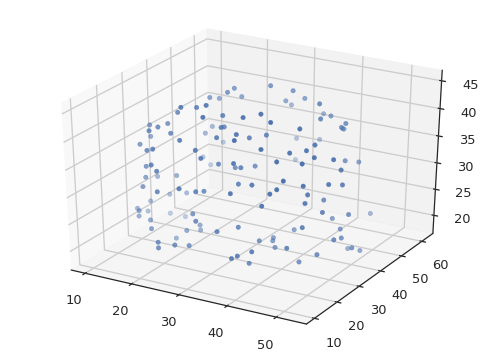

In [35]:
from mpl_toolkits.mplot3d import Axes3D

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(111, projection='3d')

ax.scatter(
    coords[:,0], coords[:,1], coords[:,2],
    marker='o'
)
f.tight_layout()

**A (3.3)**: ```human_bounds``` gives the human-labelled coordinates for the timepoint event boundaries. The i'th entry is the end boundary of the i'th event.

In [36]:
print(human_bounds)

[  26.   35.   56.   72.   86.  108.  131.  143.  157.  173.  192.  204.
  226.  313.  362.  398.  505.  526.  533.  568.  616.  634.  678.  696.
  747.  780.  870.  890.  945.  971. 1008. 1076. 1104. 1139. 1222. 1268.
 1350. 1360. 1435. 1470. 1538. 1580. 1592. 1666. 1692. 1702. 1735. 1762.
 1804. 1825. 1856. 1936. 1946.]


**Exercise 4**: <a id="ex4"></a>  Compute and visualize the timepoint-timepoint correlation matrix. 

- Is there some block-structure in the correlation matrix? Why?

**A**: Yes, but not as clear as the simulated data. The block-structure arises as scenes (blocks of timepoints) are more correlated to each other.

Text(0,0.5,'TR')

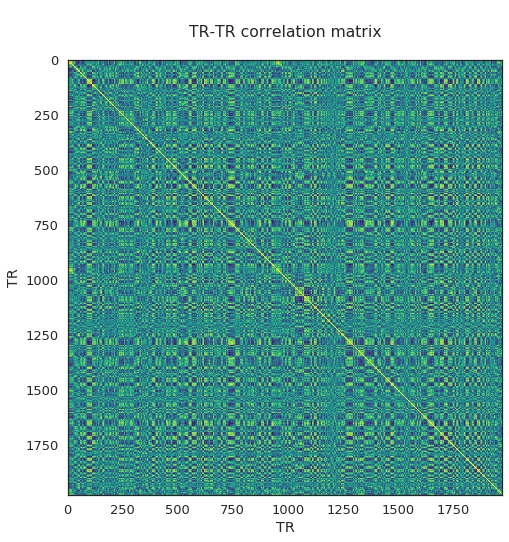

In [49]:
f, ax = plt.subplots(1,1, figsize = (10,8))
ax.imshow(np.corrcoef(np.mean(BOLD, axis=2).T), cmap='viridis')
title_text = '''
TR-TR correlation matrix
'''
ax.set_title(title_text)
ax.set_xlabel('TR')
ax.set_ylabel('TR')

Although there is a lot of potentially interesting structure here, the main thing to notice is that there are little blocks of high correlation along the diagonal. These blocks are about 30 TRs long = 45 seconds, suggesting that they are related to relatively slowly-changing features of the movie (i.e. semantically-meaningful scenes) rather than low-level properties e.g. dependent on the current camera angle.

### 1.2 Formal procedure for fitting HMM <a id="fit_hmm"></a>

Here, we introduce some rigorous procedures and relevant statistical tests. 
We need to pick `k` - the assumed number of events when fitting HMM. Then, once we figure out what `k` to use, we need some unseen data to evaluate how good the choice of `k` is. Therefore we will need to do nested cross validation. 

Here's the pseudo code: 


Given subject 1, subject 2, ... subject N. 

> <b>Outer loop</b>: Hold out subject i, for i = 1, 2, ..., N, as the final test subject. 

>> <b>Inner loop</b>: For subject j, for all j $\neq$ i, hold out some subjects as the validation set for parameter tuning and use the rest of the subjects as the training set.  

>>> For all choices of k, fit HMM on the training set, and compute the log likelihood on the validation set. 

> Then we pick the best k (based on the validation set), re-fit the model using subject j, for all j $\neq$ i. And evaluate the the performance of HMM on subject i, the final test subject. 


The code block below has the nested cv loop (without fitting HMM) to make things more concrete. 

In [21]:
# set up the nested cross validation template
n_splits_inner = 4
subj_id_all = np.array([i for i in range(nSubj)])

# set up outer loop loo structure
loo_outer = LeaveOneOut()
loo_outer.get_n_splits(subj_id_all)
for subj_id_train_outer, subj_id_test_outer in loo_outer.split(subj_id_all):
    print("Outer:\tTrain:", subj_id_train_outer, "Test:", subj_id_test_outer)
    
    # set up inner loop loo structure
    subj_id_all_inner = subj_id_all[subj_id_train_outer]
    kf = KFold(n_splits=n_splits_inner)
    kf.get_n_splits(subj_id_train_outer)
    
    print('Inner:')
    for subj_id_train_inner, subj_id_test_inner in kf.split(subj_id_all_inner):
        # inplace update the ids w.r.t. to the inner training set
        subj_id_train_inner = subj_id_all_inner[subj_id_train_inner]
        subj_id_test_inner = subj_id_all_inner[subj_id_test_inner]
        print("-Train:", subj_id_train_inner, "Test:", subj_id_test_inner, ', now try different k...')
    print()

Outer:	Train: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] Test: [0]
Inner:
-Train: [ 5  6  7  8  9 10 11 12 13 14 15 16] Test: [1 2 3 4] , now try different k...
-Train: [ 1  2  3  4  9 10 11 12 13 14 15 16] Test: [5 6 7 8] , now try different k...
-Train: [ 1  2  3  4  5  6  7  8 13 14 15 16] Test: [ 9 10 11 12] , now try different k...
-Train: [ 1  2  3  4  5  6  7  8  9 10 11 12] Test: [13 14 15 16] , now try different k...

Outer:	Train: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] Test: [1]
Inner:
-Train: [ 5  6  7  8  9 10 11 12 13 14 15 16] Test: [0 2 3 4] , now try different k...
-Train: [ 0  2  3  4  9 10 11 12 13 14 15 16] Test: [5 6 7 8] , now try different k...
-Train: [ 0  2  3  4  5  6  7  8 13 14 15 16] Test: [ 9 10 11 12] , now try different k...
-Train: [ 0  2  3  4  5  6  7  8  9 10 11 12] Test: [13 14 15 16] , now try different k...

Outer:	Train: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16] Test: [2]
Inner:
-Train: [ 5  6  7  8  9 10 11 12 13 14 15 1

Since the full nested cv procedure is time consuming, we won't do that in this notebook. Instead, we will do ... 

- 2.1 The inner loop - Split the data in a particular way (train / validation / test), fit HMM with different k and evaluate the log likelihood on some unseen subjects. 

- 2.2 The outer loop - For a fixed k, fit HMM(k) on some training set, and evaluate HMM(k) on the held-out subject. 

#### 1.2.1 The inner loop : tune `k`  <a id="tune_k"></a>



For some training set and test set, we can train HMM(`k`) on the training set and evaluate the log likelihood of the trained HMM(`k`) using the test set. For every `k`, we will get the a log likelihood. 

Then we can pick the `k`, call it `best_k`, with the largest log likelihood. If we want to evaluate how good this `best_k` is, we need other unseen data. 

Here, we pick a particular train-test split and try various `k`. 

**Exercise 5**:  <a id="ex5"></a>Estimate a reasonable value for `k`, the number of events. 

- Choose a train - validation - test split. 
- Fit HMM with `k` = 10, 20, ..., 100
- Figure out `k` works the best base on the log likelihood on the hold-out subject by plotting log likelihood against all choices of `k`. 
- Use the best `k` to predict event boundaries. 
- Overlay the boundaries on the timepoint-timepoint correlation matrix. 

In [55]:
# Choose a train - validation - test split
nSubj = BOLD.shape[2]
subj_id_all = np.array([i for i in range(nSubj)])

train_subj_id = subj_id_all[:7]
val_subj_id = subj_id_all[7:14]
test_subj_id = subj_id_all[14:]

In [75]:
k_list = range(10, 110, 10)

# keep track of log likelihoods
k_ll = []

for k in k_list:
    hmm = brainiak.eventseg.event.EventSegment(k)
    hmm.fit(BOLD[:,:,train_subj_id].mean(2).T)
    _, log_likelihood = hmm.find_events(BOLD[:,:,val_subj_id].mean(2).T)
    k_ll.append(log_likelihood)
    
# refit on train + val data with the best k
best_k = k_list[np.argmax(k_ll)]
hmm.fit(BOLD[:,:,np.append(train_subj_id, val_subj_id)].mean(2).T)

# predict event boundaries on the test set
event_boundaries, _ = hmm.find_events(BOLD[:,:,test_subj_id].mean(2).T)


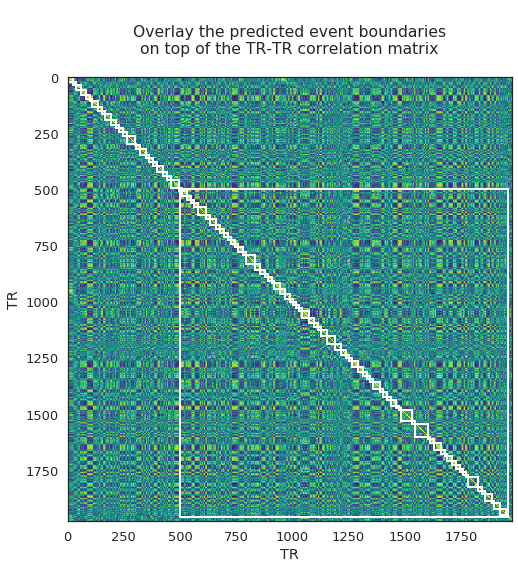

In [77]:
# Find the events in this dataset
data = BOLD.mean(2)

# extract the boundaries 
bounds = np.where(np.diff(np.argmax(event_boundaries, axis=1)))[0]

f, ax = plt.subplots(1,1, figsize = (10,8))
title_text = f'''
Overlay the predicted event boundaries
on top of the TR-TR correlation matrix
'''
plot_tt_similarity_matrix(ax, data, bounds, T, title_text)
f.tight_layout()

#### 1.2.2 Outer loop: Statistical testing for model boundaries <a id="stats_hmm"></a>
 
One way to test whether the model-identified boundaries are consistent across subjects is to fit the model on all but one subject and try to predict something about the held-out subject. There are multiple approaches for doing this (see the [Neuron supplementary material](http://www.dpmlab.org/Neuron17.pdf) for some alternatives), but the simplest is to check whether the model boundaries predict pattern changes in the held-out subject. We therefore measure whether activity patterns 5 TRs apart show a drop in correlation when they are on opposite sides of an event boundary. Here, we pick a `k` and do the full leave-one-subject-out procedure to test how good this choice is.

For comparison, we generate permuted versions of the model boundaries, in which the distribution of event lengths (the distances between the boundaries) is held constant but the order of the event lengths is shuffled. This should should have a within vs. across boundary difference of zero on average, but the variance of these null boundaries lets us know the interval of chance values and we can see that we are well above chance.

In [27]:
k = 60
w = 5  # window size
nPerm = 1000

within_across = np.zeros((nSubj, nPerm+1))
for left_out in range(nSubj):
    # Fit to all but one subject
    ev = brainiak.eventseg.event.EventSegment(k)
    ev.fit(BOLD[:,:,np.arange(nSubj) != left_out].mean(2).T)
    events = np.argmax(ev.segments_[0], axis=1)

    # Compute correlations separated by w in time
    corrs = np.zeros(nTR-w)
    for t in range(nTR-w):
        corrs[t] = pearsonr(BOLD[:,t,left_out],BOLD[:,t+w,left_out])[0]
    _, event_lengths = np.unique(events, return_counts=True)

    # Compute within vs across boundary correlations, for real and permuted bounds
    np.random.seed(0)
    for p in range(nPerm+1):
        within = corrs[events[:-w] == events[w:]].mean()
        across = corrs[events[:-w] != events[w:]].mean()
        within_across[left_out, p] = within - across
        # 
        perm_lengths = np.random.permutation(event_lengths)
        events = np.zeros(nTR, dtype=np.int)
        events[np.cumsum(perm_lengths[:-1])] = 1
        events = np.cumsum(events)
    print('Subj ' + str(left_out+1) + ': within vs across = ' + str(within_across[left_out,0]))

Subj 1: within vs across = 0.17675615357564264
Subj 2: within vs across = 0.17276013429967263
Subj 3: within vs across = 0.19725024817721035
Subj 4: within vs across = 0.19240586305522178
Subj 5: within vs across = 0.1943078856641849
Subj 6: within vs across = 0.19713975055387606
Subj 7: within vs across = 0.19113843494712124
Subj 8: within vs across = 0.21877557607707426
Subj 9: within vs across = 0.12503476857882398
Subj 10: within vs across = 0.12397142860377959
Subj 11: within vs across = 0.18584556348416928
Subj 12: within vs across = 0.1876879970093832
Subj 13: within vs across = 0.2003192598360378
Subj 14: within vs across = 0.04954726398396968
Subj 15: within vs across = 0.15189644106435962
Subj 16: within vs across = 0.16022228608220426
Subj 17: within vs across = 0.18736721787843047


Text(0,0.5,'Within vs across boundary correlation')

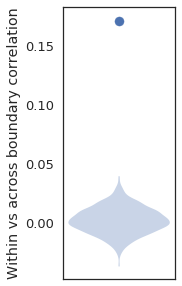

In [28]:
plt.figure(figsize=(2,5))

plt.violinplot(within_across[:,1:].mean(0), showextrema=False)
plt.scatter(1, within_across[:,0].mean(0))
plt.gca().xaxis.set_visible(False)

plt.ylabel('Within vs across boundary correlation')

**Exercise 6:** <a id="ex5"></a> Understand the logic of the stats test above. 
- How is the null distribution established? What should be the mean of the null distribution? 
- Is the result significant? What does it imply? 

**A**: The null distribution is established through random permutations of the event boundary orders. This means the mean of the null (within vs. across boundary difference) is 0 but we establish a variance for the distribution. Yes, the result is significant (the point is well outside the null distribution), which implies the correlation of these boundaries across subjects is not just by chance (they are meaningful event boundaries).

## 2. Comparing model boundaries to human-labeled boundaries  <a id="model_to_human"></a>



We can also compare the event bounds from the model to human-labeled event boundaries. Since there is some ambiguity in both the stimulus and the model about exactly which timepoint the transition occurs at, we will count two boundaries as being a "match" if they are within 3 TRs (4.5 seconds) of each other.

To determine whether the match is statistically significant, we generate permuted versions of the model boundaries as in **Section 1.2.2**. This gives as a null model for comparison (i.e. how often will a human and model bound be within 3 TRs of each other by chance?).

p = 0.007572854034573262


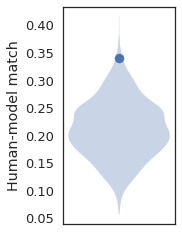

In [29]:
np.random.seed(0)

event_counts = np.diff(np.concatenate(([0],bounds,[nTR])))
nPerm = 1000
perm_bounds = bounds
threshold = 3

match = np.zeros(nPerm+1)
for p in range(nPerm+1):
    for hb in human_bounds:
        # check if match 
        if np.any(np.abs(perm_bounds - hb) <= threshold):
            match[p] += 1
    match[p] /= len(human_bounds)
    perm_counts = np.random.permutation(event_counts)
    perm_bounds = np.cumsum(perm_counts)[:-1]

plt.figure(figsize=(2,4))
plt.violinplot(match[1:], showextrema=False)
plt.scatter(1, match[0])
plt.gca().xaxis.set_visible(False)
plt.ylabel('Human-model match')
print('p = ' + str(norm.sf((match[0]-match[1:].mean())/match[1:].std())))

## 3. Aligning movie and recall data <a id="movie_to_recall"></a>

A simple model of free recall is that a subject will revisit the same sequence of events experienced during perception, but the lengths of the events will not be identical between perception and recall. We can fit this model by separately estimating event boundaries in movie and recall data, while constraining the event patterns to be the same across the two datasets.

We will now download data consisting of (group averaged) movie-watching data, and free recall data for a single subject. This data is for the angular gyrus. We also have a human-labeled correspondence between the movie and the recall (based on the transcript of the verbal recall). The full dataset for all 17 subjects is [available here](https://ndownloader.figshare.com/files/9055471).

In [10]:
D = dd.io.load('./data/AG_movie_1recall.h5')

movie = D['movie']
recall = D['recall']
movie_labels = D['movie_labels']
recall_labels = D['recall_labels']

**Exercise 7:** <a id="ex7"></a> Inspect the data: 

- Visualize the bold data for movie viewing vs. movie recall (i.e. `movie`, `recall`). 
- Visualize `movie_labels` and `recall_labels`. 
- Compare the number of TRs for the movie viewing data vs. the recall data. Do they have the same number of TRs? 

Text(0.5,1,'movie recall')

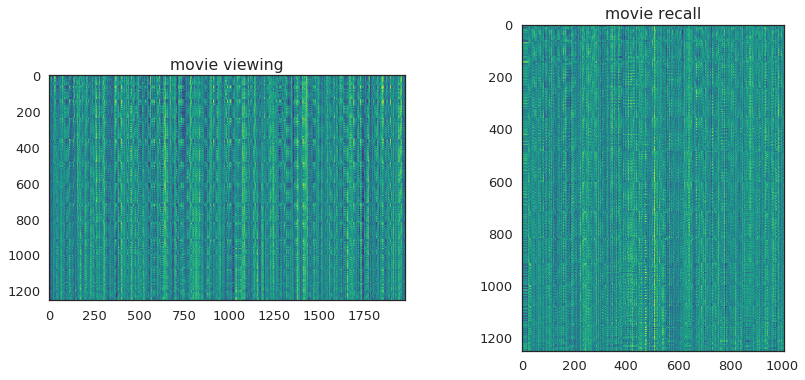

In [87]:
f, axes = plt.subplots(1,2, figsize=(14,6))
axes[0].imshow(movie, cmap='viridis')
axes[0].set_title('movie viewing')
axes[1].imshow(recall, cmap='viridis')
axes[1].set_title('movie recall')

Text(0.5,1,'movie recall')

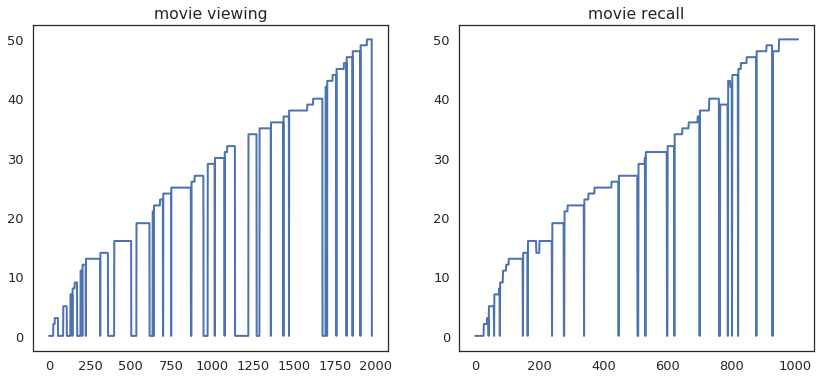

In [97]:
f, axes = plt.subplots(1,2, figsize=(14,6))
axes[0].plot(movie_labels)
axes[0].set_title('movie viewing')
axes[1].plot(recall_labels)
axes[1].set_title('movie recall')

In [95]:
print("Movie viewing data has {} TRs.".format(len(movie_labels)))
print("Movie recall data has {} TRs.".format(len(recall_labels)))

Movie viewing data has 1976 TRs.
Movie recall data has 1009 TRs.


### 3.1. Fit HMM on the two datasets  <a id="fit_movie_to_recall"></a>

We use the same fit function as for a single dataset, but now we pass in both the movie and recall datasets in a list. We assume the two datasets have shared event transitions.

In [5]:
# fit event seg models 
k = 25
hmm_ag_mvr = brainiak.eventseg.event.EventSegment(k)
hmm_ag_mvr.fit([movie.T, recall.T])

EventSegment(n_events=25, n_iter=500,
       step_var=<function EventSegment._default_var_schedule at 0x2b83ad68c488>)

This divides the movie and recall into 25 *corresponding* events, with the same 25 event patterns. We can plot the probability that each timepoint is in a particular event.

Text(0,0.5,'Events')

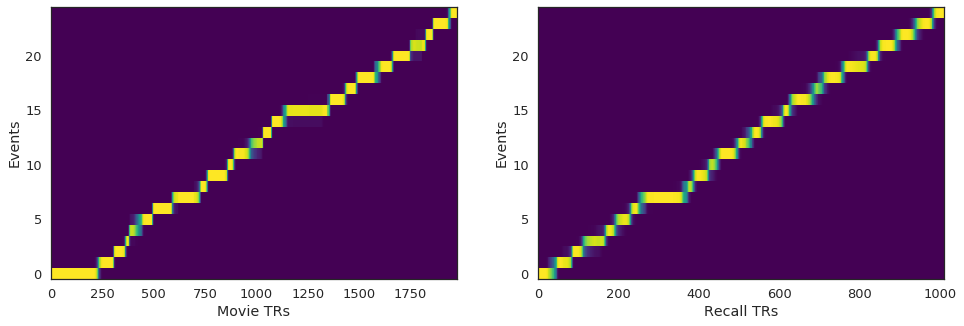

In [6]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.imshow(hmm_ag_mvr.segments_[0].T,aspect='auto',origin='lower',cmap='viridis')
plt.xlabel('Movie TRs')
plt.ylabel('Events')

plt.subplot(1,2,2)
plt.imshow(hmm_ag_mvr.segments_[1].T,aspect='auto',origin='lower',cmap='viridis')
plt.xlabel('Recall TRs')
plt.ylabel('Events')

To get the temporal correspondence between the movie and the recall, we need to find the probability that a movie TR and a recall TR are in the same event (regardless of which event it is). This is
$$
\sum_k p(T_M == k) \cdot p(T_R == k)
$$
which we can compute by a simple matrix multiplication.

For comparison, we also plot the human-labeled correspondence as white boxes.

Text(0.5,1,'\nEstimated temporal correspondence, movie vs. recall\nhuman labels overlayed as bounding boxes\nROI = AG\n')

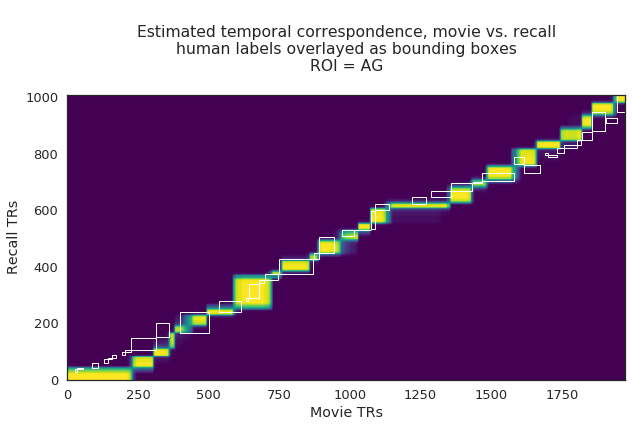

In [35]:
f, ax = plt.subplots(1,1, figsize=(10,8))    

ax.imshow(
    np.dot(hmm_ag_mvr.segments_[1], hmm_ag_mvr.segments_[0].T),
    origin='lower',cmap='viridis'
)

# overlay the boundaries 
for i in np.unique(movie_labels[movie_labels>0]):
    if not np.any(recall_labels==i):
        continue
    movie_start = np.where(movie_labels==i)[0][0]
    movie_end = np.where(movie_labels==i)[0][-1]
    recall_start = np.where(recall_labels==i)[0][0]
    recall_end = np.where(recall_labels==i)[0][-1]

    rect = patches.Rectangle(
        (movie_start-0.5, recall_start-0.5), 
        movie_end - movie_start + 1,
        recall_end - recall_start + 1, 
        linewidth=1,edgecolor='w',facecolor='none'
    )
    ax.add_patch(rect)
ax.set_xlabel('Movie TRs')
ax.set_ylabel('Recall TRs')

title_text = """
Estimated temporal correspondence, movie vs. recall
human labels overlayed as bounding boxes
ROI = AG
"""
ax.set_title(title_text)

### 3.2 Compare the time scale of events between semantic and sensory regions.   <a id="movie_to_recall_semantic_sensory"></a>

Run HMM on 2 ROIs that correspond to semantic (PMC - posterior medial cortex) and sensory processing (auditory coretx) regions. These regions show differences in their time scales of processing, reflecting low-level sensory processing and high-level cognitive processing.

In [3]:
# data root 
sherlock_dir = '/home/NEU480/datasets/Sherlock_processed'

In [4]:
def load_labels(subj_id): 
    label_fname = f'labels_subj{subj_id}.mat'
    labels = scipy.io.loadmat(os.path.join(sherlock_dir, 'labels', label_fname))
    recall_times = labels['recall_scenetimes']
    movie_times = labels['subj_movie_scenetimes']
#     print(f'label: \n- recall: {len(recall_times)} \n- movie: {len(movie_times)}')
    return recall_times, movie_times

def read_sherlock_mat_data(fpath):
    temp = scipy.io.loadmat(fpath)
    return temp['rdata'].T

**Exercise 8:** <a id="ex8"></a> Fit the HMM to find temporal correspondence between movie vs. recall, for both ROIs. 

- *Inspect the data again. 
- Perform the analysis. Which ROI had a better fit? 

**Note:** For many subjects, the distinction is small. The ROI-difference on subject 2 should be big enough so that you can eyeball it. The following code loads the data for subject 2, but please also explore this phenomenon for other subjects. 


**A**: AUD had a better fit (see graphs below)

In [5]:
subj_id = 2 

data_dir_subj = os.path.join(sherlock_dir, 'data_mat', f's{subj_id}')
recall_dir = os.path.join(data_dir_subj, 'sherlock_recall')
movie_dir = os.path.join(data_dir_subj, 'sherlock_movie')

# load data 
fpath_aud_movie  = os.path.join(movie_dir, f'aud_early_sherlock_movie_s{subj_id}.mat')
fpath_aud_recall = os.path.join(recall_dir, f'aud_early_sherlock_recall_s{subj_id}.mat') 

fpath_pmc_movie  = os.path.join(movie_dir, f'pmc_nn_sherlock_movie_s{subj_id}.mat')
fpath_pmc_recall = os.path.join(recall_dir, f'pmc_nn_sherlock_recall_s{subj_id}.mat')

data_aud_movie = read_sherlock_mat_data(fpath_aud_movie)
data_aud_recall = read_sherlock_mat_data(fpath_aud_recall)

data_pmc_movie = read_sherlock_mat_data(fpath_pmc_movie)
data_pmc_recall = read_sherlock_mat_data(fpath_pmc_recall)

# load labels
recall_times, movie_times = load_labels(subj_id)

In [15]:
# fit event seg models 
k = 25
hmm_aud_mvr = brainiak.eventseg.event.EventSegment(k)
hmm_aud_mvr.fit([data_aud_movie, data_aud_recall])

EventSegment(n_events=25, n_iter=500,
       step_var=<function EventSegment._default_var_schedule at 0x2b83ad68c488>)

In [16]:
# fit event seg models 
k = 25
hmm_pmc_mvr = brainiak.eventseg.event.EventSegment(k)
hmm_pmc_mvr.fit([data_pmc_movie, data_pmc_recall])

EventSegment(n_events=25, n_iter=500,
       step_var=<function EventSegment._default_var_schedule at 0x2b83ad68c488>)

Text(0.5,1,'\nEstimated temporal correspondence, movie vs. recall\nhuman labels overlayed as bounding boxes\nROI = AUD\n')

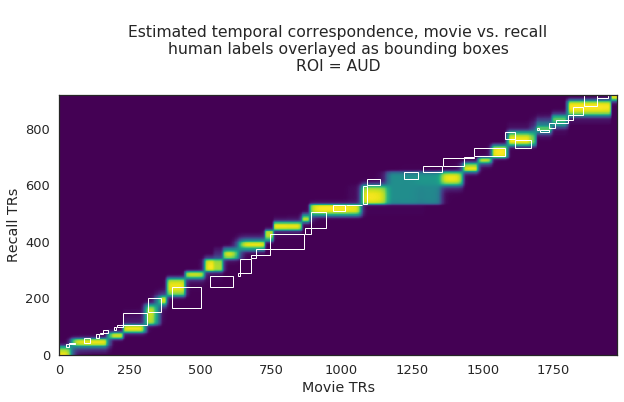

In [17]:
f, ax = plt.subplots(1,1, figsize=(10,8))    

ax.imshow(
    np.dot(hmm_aud_mvr.segments_[1], hmm_aud_mvr.segments_[0].T),
    origin='lower',cmap='viridis'
)

# overlay the boundaries 
for i in np.unique(movie_labels[movie_labels>0]):
    if not np.any(recall_labels==i):
        continue
    movie_start = np.where(movie_labels==i)[0][0]
    movie_end = np.where(movie_labels==i)[0][-1]
    recall_start = np.where(recall_labels==i)[0][0]
    recall_end = np.where(recall_labels==i)[0][-1]

    rect = patches.Rectangle(
        (movie_start-0.5, recall_start-0.5), 
        movie_end - movie_start + 1,
        recall_end - recall_start + 1, 
        linewidth=1,edgecolor='w',facecolor='none'
    )
    ax.add_patch(rect)
ax.set_xlabel('Movie TRs')
ax.set_ylabel('Recall TRs')

title_text = """
Estimated temporal correspondence, movie vs. recall
human labels overlayed as bounding boxes
ROI = AUD
"""
ax.set_title(title_text)

Text(0.5,1,'\nEstimated temporal correspondence, movie vs. recall\nhuman labels overlayed as bounding boxes\nROI = PMC\n')

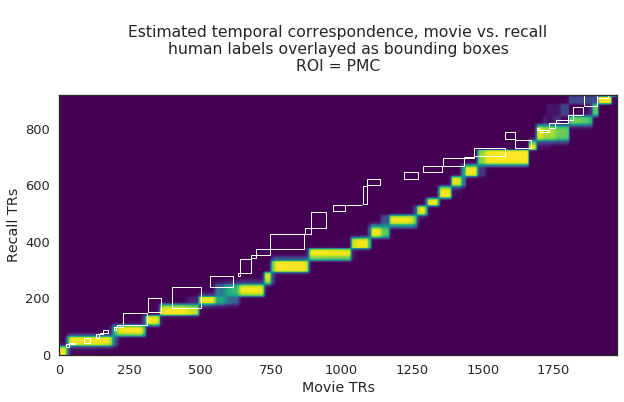

In [18]:
f, ax = plt.subplots(1,1, figsize=(10,8))    

ax.imshow(
    np.dot(hmm_pmc_mvr.segments_[1], hmm_pmc_mvr.segments_[0].T),
    origin='lower',cmap='viridis'
)

# overlay the boundaries 
for i in np.unique(movie_labels[movie_labels>0]):
    if not np.any(recall_labels==i):
        continue
    movie_start = np.where(movie_labels==i)[0][0]
    movie_end = np.where(movie_labels==i)[0][-1]
    recall_start = np.where(recall_labels==i)[0][0]
    recall_end = np.where(recall_labels==i)[0][-1]

    rect = patches.Rectangle(
        (movie_start-0.5, recall_start-0.5), 
        movie_end - movie_start + 1,
        recall_end - recall_start + 1, 
        linewidth=1,edgecolor='w',facecolor='none'
    )
    ax.add_patch(rect)
ax.set_xlabel('Movie TRs')
ax.set_ylabel('Recall TRs')

title_text = """
Estimated temporal correspondence, movie vs. recall
human labels overlayed as bounding boxes
ROI = PMC
"""
ax.set_title(title_text)

**Novel contribution** <a id="novel"></a>

1. Use different ROIs and replicate Figure 4. in Baldassano et al., 2017.
2. Use RSA to compare all movie viewing patterns vs. all movie recall patterns. 
3. Use inter-subject methods to analyze this data. 

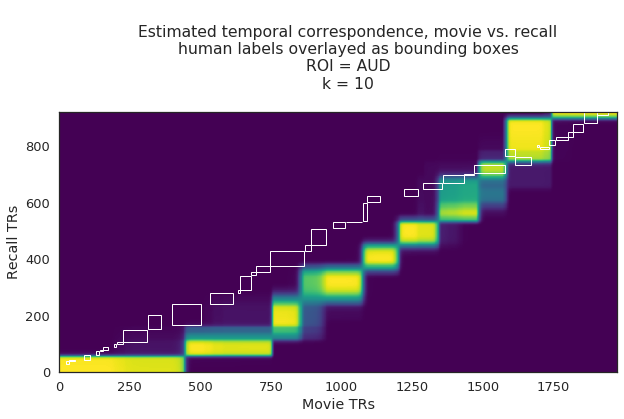

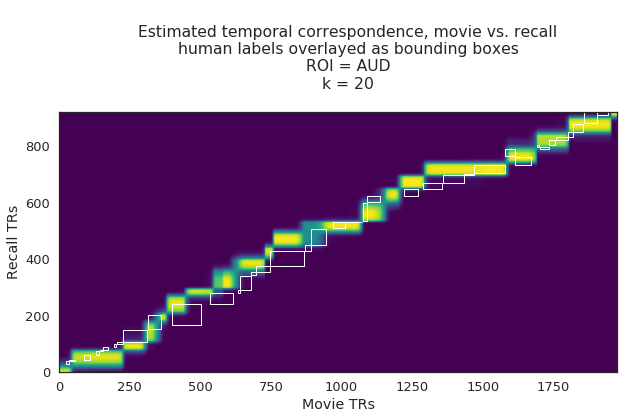

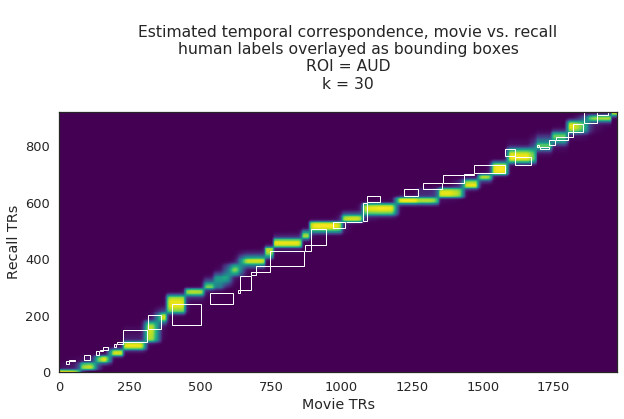

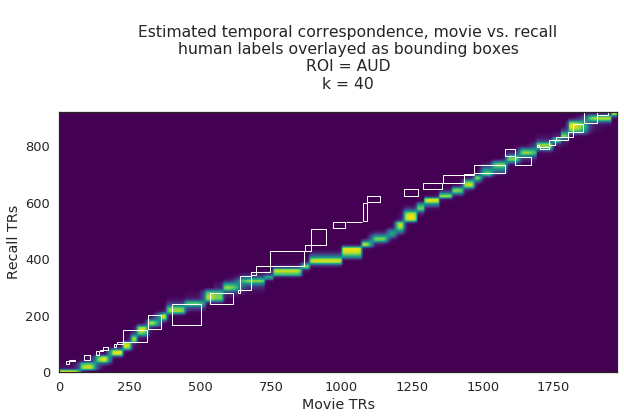

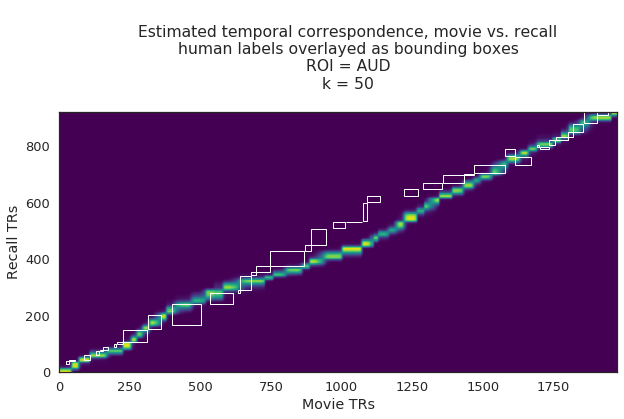

In [11]:
# Try diff values of K for AUD
k_list = range(10, 60, 10)

for k in k_list:
    # fit event seg models 
    hmm_aud_mvr = brainiak.eventseg.event.EventSegment(k)
    hmm_aud_mvr.fit([data_aud_movie, data_aud_recall])
    
    f, ax = plt.subplots(1,1, figsize=(10,8))    

    ax.imshow(
        np.dot(hmm_aud_mvr.segments_[1], hmm_aud_mvr.segments_[0].T),
        origin='lower',cmap='viridis'
    )

    # overlay the boundaries 
    for i in np.unique(movie_labels[movie_labels>0]):
        if not np.any(recall_labels==i):
            continue
        movie_start = np.where(movie_labels==i)[0][0]
        movie_end = np.where(movie_labels==i)[0][-1]
        recall_start = np.where(recall_labels==i)[0][0]
        recall_end = np.where(recall_labels==i)[0][-1]

        rect = patches.Rectangle(
            (movie_start-0.5, recall_start-0.5), 
            movie_end - movie_start + 1,
            recall_end - recall_start + 1, 
            linewidth=1,edgecolor='w',facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_xlabel('Movie TRs')
    ax.set_ylabel('Recall TRs')

    title_text = """
    Estimated temporal correspondence, movie vs. recall
    human labels overlayed as bounding boxes
    ROI = AUD
    k = {}
    """.format(k)
    ax.set_title(title_text)
    plt.show()

### Recommended readings

- Anderson, J. R., Pyke, A. A., & Fincham, J. M. (2016). Hidden Stages of Cognition Revealed in Patterns of Brain Activation. Psychological Science, 27(9), 1215–1226. https://doi.org/10.1177/0956797616654912

- Baldassano, C., Hasson, U., & Norman, K. A. (2018). Representation of Real-World Event Schemas during Narrative Perception. The Journal of Neuroscience: The Official Journal of the Society for Neuroscience, 38(45), 9689–9699. https://doi.org/10.1523/JNEUROSCI.0251-18.2018

- Manning, J. R., Fitzpatrick, P. C., & Heusser, A. C. (2018). How is experience transformed into memory? bioRxiv. https://doi.org/10.1101/409987

### Contributions <a id="contributions"></a>

- Chris Baldassano developed the initial notebook for 
<a href="https://github.com/brainiak/brainiak/blob/master/examples/eventseg/HiddenMarkovModels.ipynb">brainiak demo</a>. 
- Q add exs; nested cv; tune k; modularize code. 
- M. Kumar added introduction and edited section descriptions. 
- Ken Norman made final edits to the notebook.